# Figure 4

In [1]:
import numpy as np
import xarray as xr
from glob import glob
from datetime import timedelta

import cosima_cookbook as cc

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import matplotlib.colors as col

import cartopy.crs as ccrs
import cmocean.cm as cmo

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46559/status,
Dashboard: /proxy/46559/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45057,Workers: 7
Dashboard: /proxy/46559/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:36333,Total threads: 4
Dashboard: /proxy/38173/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:32887,


### Start database sessions

In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for future scenario simulation
session_dir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/databases/SSP2100_experiments_nodaily.db'
expt_session = cc.database.create_session(session_dir)
expt_ssp245 = '01deg_jra55v13_ryf9091_ssp245'
expt_ssp245mw = '01deg_jra55v13_ryf9091_ssp245_mw'
expt_ssp585 = '01deg_jra55v13_ryf9091_ssp585'
expt_ssp585mw = '01deg_jra55v13_ryf9091_ssp585_mw'

### Extract timeseries of sea ice volume, thickness and concentration and save to file

In [7]:
start_time='2150-01-01'
end_time='2165-01-01'

lat_slice = slice(-85,-50)
lon_slice = slice(-280,80)
isobath_depth = 1000

# Get grid info
area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)
area_t_so = area_t.sel(yt_ocean=lat_slice)

In [8]:
def rename_coords(var, area_t):
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    return var

def shift_time(var):
    var['time'] = var.time.to_pandas() - timedelta(hours = 12)
    return var

def import_seaice(expt, session, start_time, end_time, lat_slice):
    print(expt)
    
    time_slice = slice(start_time, end_time)
    
    # read in data
    hi = cc.querying.getvar(expt, 'hi_m', session, frequency='1 monthly', start_time=start_time, end_time=end_time).sel(time=time_slice)
    aice = cc.querying.getvar(expt, 'aice_m', session, frequency='1 monthly', start_time=start_time, end_time=end_time).sel(time=time_slice)
    
    # replace coordinates with lat & lon (we're looking at SH only so this is fine)
    hi = rename_coords(hi, area_t)
    aice = rename_coords(aice, area_t)
    
    # shift time coordinate back 12 hours to make sure it is in the correct month
    hi = shift_time(hi).sel(time=time_slice)
    aice = shift_time(aice).sel(time=time_slice)
   
    # Restrict to latitude range of interest
    hi = hi.sel(yt_ocean=lat_slice)
    aice = aice.sel(yt_ocean=lat_slice)
   
    return hi, aice
    
def calculate_volume(concentration, thickness):
    # Calculate sea ice volume, convert to km^3 and rename dataarray
    vi = concentration * area_t * thickness * 1e-9
    vi = vi.rename('vi')
    return vi

Read in whole timeseries of ice thickness and concentration. 

In [6]:
%%time
# control 
hi_cntl, aice_cntl = import_seaice(control, master_session, start_time, end_time, lat_slice)
# experiments
hi_ssp245, aice_ssp245 = import_seaice(expt_ssp245, expt_session, start_time, end_time, lat_slice)
hi_ssp245mw, aice_ssp245mw = import_seaice(expt_ssp245mw, expt_session, start_time, end_time, lat_slice)
hi_ssp585, aice_ssp585 = import_seaice(expt_ssp585, expt_session, start_time, end_time, lat_slice)
hi_ssp585mw, aice_ssp585mw = import_seaice(expt_ssp585mw, expt_session, start_time, end_time, lat_slice)

01deg_jra55v13_ryf9091
01deg_jra55v13_ryf9091_ssp245
01deg_jra55v13_ryf9091_ssp245_mw
01deg_jra55v13_ryf9091_ssp585
01deg_jra55v13_ryf9091_ssp585_mw
CPU times: user 17min 57s, sys: 8min 7s, total: 26min 4s
Wall time: 38min 51s


Calculate volume timeseries

In [7]:
%%time
# calculate sea ice volume
# control
vi_cntl = calculate_volume(aice_cntl, hi_cntl)
# experiments
vi_ssp245 = calculate_volume(aice_ssp245, hi_ssp245)
vi_ssp245mw = calculate_volume(aice_ssp245mw, hi_ssp245mw)
vi_ssp585 = calculate_volume(aice_ssp585, hi_ssp585)
vi_ssp585mw = calculate_volume(aice_ssp585mw, hi_ssp585mw)

CPU times: user 70.8 ms, sys: 10.9 ms, total: 81.7 ms
Wall time: 209 ms


Load into memory for saving to file. 

In [8]:
%%time
# CONTROL
hi_cntl = hi_cntl.compute()
aice_cntl = aice_cntl.compute()
vi_cntl = vi_cntl.compute()

# SSP245
hi_ssp245 = hi_ssp245.compute()
aice_ssp245 = aice_ssp245.compute()
vi_ssp245 = vi_ssp245.compute()

# SSP245-MW
hi_ssp245mw = hi_ssp245mw.compute()
aice_ssp245mw = aice_ssp245mw.compute()
vi_ssp245mw = vi_ssp245mw.compute()

# SSP585 
hi_ssp585 = hi_ssp585.compute()
aice_ssp585 = aice_ssp585.compute()
vi_ssp585 = vi_ssp585.compute()

# SSP585-MW
hi_ssp585mw = hi_ssp585mw.compute()
aice_ssp585mw = aice_ssp585mw.compute()
vi_ssp585mw = vi_ssp585mw.compute()

CPU times: user 3min 34s, sys: 6min 47s, total: 10min 21s
Wall time: 12min 3s


Incorporate into one dataset and save back to file for easy plotting later.

In [9]:
outdir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/seaice_timeseries/'

In [12]:
# CONTROL
outfile = outdir + 'control_timeseries.nc'
ds_cntl = vi_cntl.to_dataset()
ds_cntl.vi.attrs['Long name'] = 'sea ice volume'
ds_cntl.vi.attrs['Units'] = 'km3'
ds_cntl['aice'] = aice_cntl
ds_cntl['hi'] = hi_cntl

# experiments
# SSP245
ds_ssp245 = vi_ssp245.to_dataset()
ds_ssp245.vi.attrs['Long name'] = 'sea ice volume'
ds_ssp245.vi.attrs['Units'] = 'km3'
ds_ssp245['aice'] = aice_ssp245
ds_ssp245['hi'] = hi_ssp245

# SSP245 MW
ds_ssp245mw = vi_ssp245mw.to_dataset()
ds_ssp245mw.vi.attrs['Long name'] = 'sea ice volume'
ds_ssp245mw.vi.attrs['Units'] = 'km3'
ds_ssp245mw['aice'] = aice_ssp245mw
ds_ssp245mw['hi'] = hi_ssp245mw

# SSP585
ds_ssp585 = vi_ssp585.to_dataset()
ds_ssp585.vi.attrs['Long name'] = 'sea ice volume'
ds_ssp585.vi.attrs['Units'] = 'km3'
ds_ssp585['aice'] = aice_ssp585
ds_ssp585['hi'] = hi_ssp585

# SSP585 MW
ds_ssp585mw = vi_ssp585mw.to_dataset()
ds_ssp585mw.vi.attrs['Long name'] = 'sea ice volume'
ds_ssp585mw.vi.attrs['Units'] = 'km3'
ds_ssp585mw['aice'] = aice_ssp585mw
ds_ssp585mw['hi'] = hi_ssp585mw

Save to file. 

In [29]:
%%time
# CONTROL
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in ds_cntl.data_vars}
print(f'Saving to {outfile}')
ds_cntl.to_netcdf(outfile, encoding=encoding)

# SSP245
outfile = outdir + 'ssp245_timeseries.nc'
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in ds_ssp245.data_vars}
print(f'Saving to {outfile}')
ds_ssp245.to_netcdf(outfile, encoding=encoding)

# SSP245 MW
outfile = outdir + 'ssp245mw_timeseries.nc'
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in ds_ssp245mw.data_vars}
print(f'Saving to {outfile}')
ds_ssp245mw.to_netcdf(outfile, encoding=encoding)

# SSP585
outfile = outdir + 'ssp585_timeseries.nc'
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in ds_ssp585.data_vars}
print(f'Saving to {outfile}')
ds_ssp585.to_netcdf(outfile, encoding=encoding)

# SSP585 MW
outfile = outdir + 'ssp585mw_timeseries.nc'
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in ds_ssp585mw.data_vars}
print(f'Saving to {outfile}')
ds_ssp585mw.to_netcdf(outfile, encoding=encoding)

Saving to /g/data/e14/hd4873/access-om2-01/project03_misc_data/seaice_timeseries/ssp245_timeseries.nc
Saving to /g/data/e14/hd4873/access-om2-01/project03_misc_data/seaice_timeseries/ssp245mw_timeseries.nc
Saving to /g/data/e14/hd4873/access-om2-01/project03_misc_data/seaice_timeseries/ssp585_timeseries.nc
Saving to /g/data/e14/hd4873/access-om2-01/project03_misc_data/seaice_timeseries/ssp585mw_timeseries.nc
CPU times: user 4min 19s, sys: 6.38 s, total: 4min 26s
Wall time: 4min 24s


### Reload timeseries data

In [4]:
outdir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/seaice_timeseries/'
ds_cntl = xr.open_dataset(outdir + 'control_timeseries.nc').load()
ds_ssp245 = xr.open_dataset(outdir + 'ssp245_timeseries.nc').load()
ds_ssp245mw = xr.open_dataset(outdir + 'ssp245mw_timeseries.nc').load()
ds_ssp585 = xr.open_dataset(outdir + 'ssp585_timeseries.nc').load()
ds_ssp585mw = xr.open_dataset(outdir + 'ssp585mw_timeseries.nc').load()

Define function to calculate extent and sea ice area

In [5]:
def calculate_extent(concentration, area_t):
    extent = xr.where(concentration >= 0.15, area_t, 0.).sum('xt_ocean').sum('yt_ocean')
    return extent

def calculate_area(concentration, area_t):
    area = (concentration * area_t).sum('xt_ocean').sum('yt_ocean')
    return area

Calculate sea ice extent (in the simulations)

In [9]:
area_t_so = area_t.sel(yt_ocean=lat_slice)

extent_cntl = calculate_extent(ds_cntl.aice, area_t_so).compute()
extent_ssp245 = calculate_extent(ds_ssp245.aice, area_t_so).compute()
extent_ssp245mw = calculate_extent(ds_ssp245mw.aice, area_t_so).compute()
extent_ssp585 = calculate_extent(ds_ssp585.aice, area_t_so).compute()
extent_ssp585mw = calculate_extent(ds_ssp585mw.aice, area_t_so).compute()

Calculate sea ice extent (in the simulations)

In [10]:
area_cntl = calculate_area(ds_cntl.aice, area_t_so).compute()
area_ssp245 = calculate_area(ds_ssp245.aice, area_t_so).compute()
area_ssp245mw = calculate_area(ds_ssp245mw.aice, area_t_so).compute()
area_ssp585 = calculate_area(ds_ssp585.aice, area_t_so).compute()
area_ssp585mw = calculate_area(ds_ssp585mw.aice, area_t_so).compute()

Calculate climatology for each simulation, using the last 5 years. 

In [25]:
start_time_clim = '2160-01-01'
end_time_clim = '2164-12-31'
time_slice_clim = slice(start_time_clim, end_time_clim)

extent_clim_cntl = extent_cntl.sel(time=time_slice_clim).groupby('time.month').mean(dim='time')
extent_clim_ssp245 = extent_ssp245.sel(time=time_slice_clim).groupby('time.month').mean(dim='time')
extent_clim_ssp245mw = extent_ssp245mw.sel(time=time_slice_clim).groupby('time.month').mean(dim='time')
extent_clim_ssp585 = extent_ssp585.sel(time=time_slice_clim).groupby('time.month').mean(dim='time')
extent_clim_ssp585mw = extent_ssp585mw.sel(time=time_slice_clim).groupby('time.month').mean(dim='time')

In [26]:
area_clim_cntl = area_cntl.sel(time=time_slice_clim).groupby('time.month').mean(dim='time')
area_clim_ssp245 = area_ssp245.sel(time=time_slice_clim).groupby('time.month').mean(dim='time')
area_clim_ssp245mw = area_ssp245mw.sel(time=time_slice_clim).groupby('time.month').mean(dim='time')
area_clim_ssp585 = area_ssp585.sel(time=time_slice_clim).groupby('time.month').mean(dim='time')
area_clim_ssp585mw = area_ssp585mw.sel(time=time_slice_clim).groupby('time.month').mean(dim='time')

### Read in ice growth diagnostic

In [11]:
start_time='2160-01-01'
end_time='2165-01-01'

In [36]:
def import_seaice(expt, session, start_time, end_time, lat_slice):
    print(expt)
    
    time_slice = slice(start_time, end_time)
    
    # read in data
    congel = cc.querying.getvar(expt, 'congel_m', session, frequency='1 monthly', 
                                start_time=start_time, end_time=end_time).sel(time=time_slice)
    frazil = cc.querying.getvar(expt, 'frazil_m', session, frequency='1 monthly', 
                                start_time=start_time, end_time=end_time).sel(time=time_slice)
    
    # replace coordinates with lat & lon (we're looking at SH only so this is fine)
    congel = rename_coords(congel, area_t)
    frazil = rename_coords(frazil, area_t)
    
    # shift time coordinate back 12 hours to make sure it is in the correct month
    congel = shift_time(congel).sel(time=time_slice)
    frazil = shift_time(frazil).sel(time=time_slice)

    # Restrict to latitude range of interest
    congel = congel.sel(yt_ocean=lat_slice)
    frazil = frazil.sel(yt_ocean=lat_slice)
    
    return congel, frazil

In [13]:
%%time
# control
congel_cntl, frazil_cntl = import_seaice(control, master_session, start_time, end_time, lat_slice)

# experiments
congel_ssp245, frazil_ssp245 = import_seaice(expt_ssp245, expt_session, start_time, end_time, lat_slice)
congel_ssp245mw, frazil_ssp245mw = import_seaice(expt_ssp245mw, expt_session, start_time, end_time, lat_slice)
congel_ssp585, frazil_ssp585 = import_seaice(expt_ssp585, expt_session, start_time, end_time, lat_slice)
congel_ssp585mw, frazil_ssp585mw = import_seaice(expt_ssp585mw, expt_session, start_time, end_time, lat_slice)

01deg_jra55v13_ryf9091
01deg_jra55v13_ryf9091_ssp245
01deg_jra55v13_ryf9091_ssp245_mw
01deg_jra55v13_ryf9091_ssp585
01deg_jra55v13_ryf9091_ssp585_mw
CPU times: user 3min 3s, sys: 1min 25s, total: 4min 29s
Wall time: 6min 42s


We want to plot the mean sea ice growth rates averaged over the continental shelf. So we need to mask this dataset to the shelf. 

In [14]:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask
    
    return masked_var

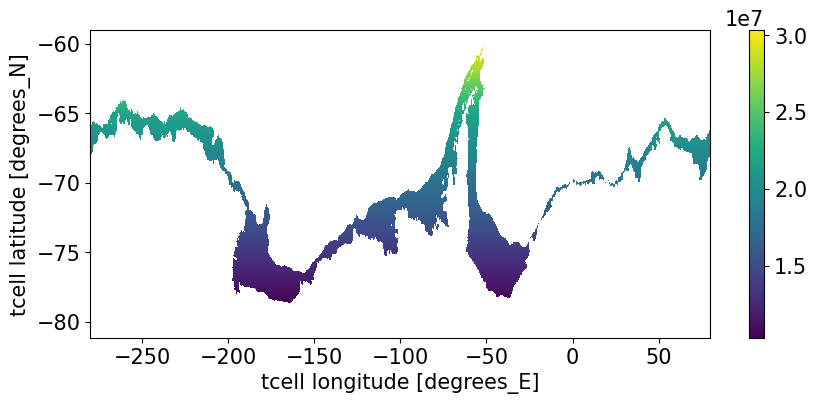

In [33]:
area_shelf_mask = shelf_mask_isobath(area_t) * (congel_cntl.isel(time=0).drop('time')*0+1)
area_shelf_mask.plot(figsize=(10, 4)); # double check this has worked

area_shelf_sum = area_shelf_mask.sum(['xt_ocean', 'yt_ocean'])

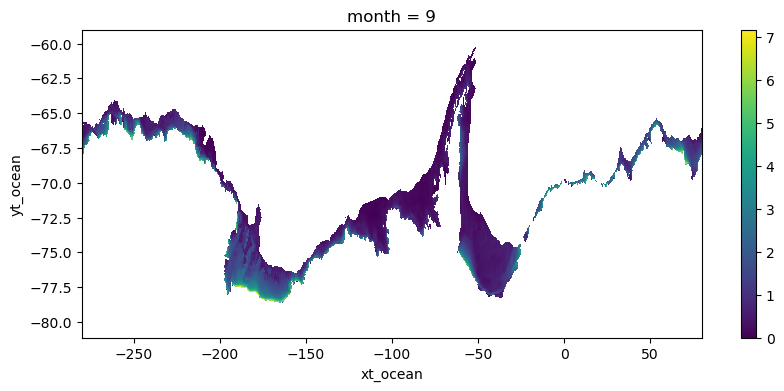

In [21]:
congel_cntl_shelf = shelf_mask_isobath(congel_cntl.groupby('time.month').mean())
congel_ssp245_shelf = shelf_mask_isobath(congel_ssp245.groupby('time.month').mean())
congel_ssp245mw_shelf = shelf_mask_isobath(congel_ssp245mw.groupby('time.month').mean())
congel_ssp585_shelf = shelf_mask_isobath(congel_ssp585.groupby('time.month').mean())
congel_ssp585mw_shelf = shelf_mask_isobath(congel_ssp585mw.groupby('time.month').mean())

frazil_cntl_shelf = shelf_mask_isobath(frazil_cntl.groupby('time.month').mean())
frazil_ssp245_shelf = shelf_mask_isobath(frazil_ssp245.groupby('time.month').mean())
frazil_ssp245mw_shelf = shelf_mask_isobath(frazil_ssp245mw.groupby('time.month').mean())
frazil_ssp585_shelf = shelf_mask_isobath(frazil_ssp585.groupby('time.month').mean())
frazil_ssp585mw_shelf = shelf_mask_isobath(frazil_ssp585mw.groupby('time.month').mean())

congel_cntl_shelf.isel(month=8).plot(figsize=(10, 4)); # again, double check the masking worked

### Read in sea ice observations
Monthly means, not daily. 

In [17]:
import os
from glob import glob
import pandas as pd
from datetime import datetime

In [23]:
def load_sea_ice_obs_extent(filelist):
    """
    Return xarray DataSet of sea ice extent and area from NOAA/G02135 csv file list (monthly from 1978 to Feb 2025)
    """
    
    df = pd.concat([pd.read_csv(f) for f in filelist])  
    df.columns = df.columns.str.strip() 
    df['time'] = df.apply(lambda r: datetime(r['year'], r['mo'], 1), axis=1)  # make a date column (set day=1 to match cice output)
    df = df.drop(columns=['year', 'mo', 'data-type', 'region'])  
    num = df._get_numeric_data()
    num[num < 0] = np.nan 
    df = df.sort_values('time')
    
    ds = df.to_xarray()  
    ds = ds.assign_coords(index=ds['time']).drop('time')  
    ds['extent'] = ds.extent.rename({'index': 'time'})  
    ds['area'] = ds.area.rename({'index': 'time'})  
    ds = ds.drop('index')  
    ds = ds*1e12  # convert from Million km^2 to m^2
    
    return ds

In [24]:
obs_files = sorted(glob('/scratch/e14/hd4873/obs_sea_ice/nsidc/monthly/S_*_extent_v3.0.csv'))
obs_seaice = load_sea_ice_obs_extent(obs_files)

# select out 1979 - 2024 climatology
obs_seaice = obs_seaice.sel(time=slice('1979','2024'))

# select out May 1990 to April 1991 climatology
timerange = slice(pd.to_datetime('1990-05-01', format='%Y-%m-%d'),
                  pd.to_datetime('1991-04-30', format='%Y-%m-%d'))
obs_seaice_9091 = obs_seaice.sel(time=timerange).groupby('time.month').mean('time', skipna=True)

# now calculate observational climatology and std
obs_seaice_clim = obs_seaice.groupby('time.month').mean('time', skipna=True)
obs_seaice_std = obs_seaice.groupby('time.month').std('time', skipna=True)

### Plot climatology

Mean sea ice growth, rather than integrated. 

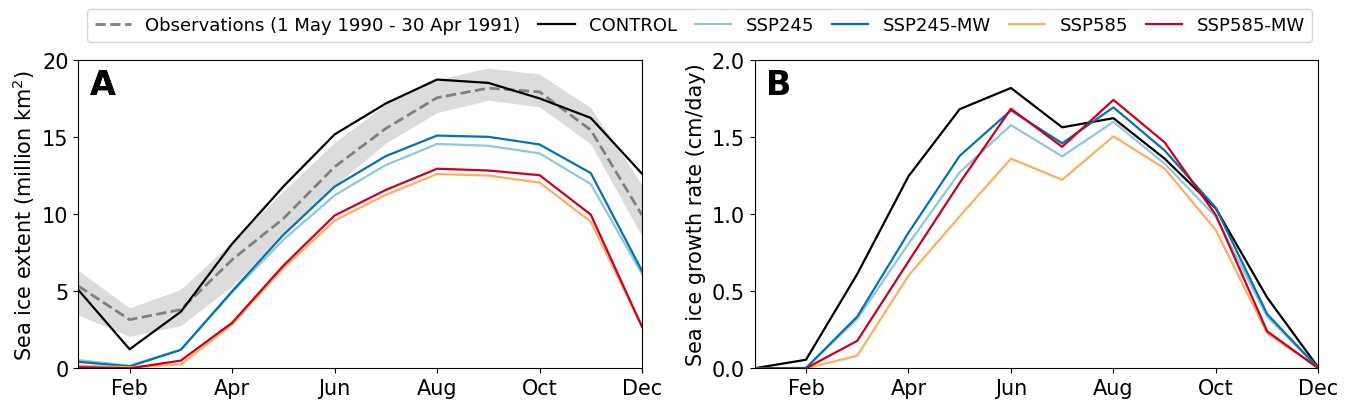

In [40]:
c1, c2, c3, c4, c5 = '#92c5de', '#0571b0', '#fdae61', '#ca0020', 'navy'
labels= ['A','B','C']
x = np.arange(1, 13, 1)
lw = 1.6

# start figure
plt.rcParams['font.size'] = 15
fig,axes = plt.subplots(ncols=2, figsize=(16, 4), sharex=True)
plt.subplots_adjust(wspace=0.2)
for i, ax in enumerate(axes):
    ax.text(0.02, 0.89, f'{labels[i]}', c='k', fontsize=24, fontweight='bold', transform=ax.transAxes)

# SIE
lw = 1.6
# plot observations from 1990 to 1991
axes[0].plot(x, obs_seaice_9091.extent/1e12, lw=2, ls='--', 
             color='grey', label="Observations (1 May 1990 - 30 Apr 1991)")

# shade standard deviation
axes[0].fill_between(x, (obs_seaice_clim.extent - 2*obs_seaice_std.extent)/1e12, 
                     (obs_seaice_clim.extent + 2*obs_seaice_std.extent)/1e12, 
                     lw=0, ls='-', color='gainsboro',)

axes[0].plot(x, extent_clim_cntl/1e12, lw=lw, color='k', label="CONTROL")
axes[0].plot(x, extent_clim_ssp245/1e12, lw=lw, color=c1, label="SSP245")
axes[0].plot(x, extent_clim_ssp245mw/1e12, lw=lw, color=c2, label="SSP245-MW")
axes[0].plot(x, extent_clim_ssp585/1e12, lw=lw, color=c3, label="SSP585")
axes[0].plot(x, extent_clim_ssp585mw/1e12, lw=lw, color=c4, label="SSP585-MW")
axes[0].text(0.02, 0.89, f'{labels[0]}',  c='k', fontsize=24, fontweight='bold',transform=axes[0].transAxes)

# ice growth rates (congel + frazil) averaged over the shelf 
((congel_cntl_shelf + frazil_cntl_shelf) * area_shelf_mask / area_shelf_sum).sum(['xt_ocean', 'yt_ocean']).plot(ax=axes[1], lw=lw, c='k')
((congel_ssp245_shelf + frazil_ssp245_shelf) * area_shelf_mask / area_shelf_sum).sum(['xt_ocean', 'yt_ocean']).plot(ax=axes[1], lw=lw, c=c1)
((congel_ssp245mw_shelf + frazil_ssp245mw_shelf) * area_shelf_mask / area_shelf_sum).sum(['xt_ocean', 'yt_ocean']).plot(ax=axes[1], lw=lw, c=c2)
((congel_ssp585_shelf + frazil_ssp585_shelf) * area_shelf_mask / area_shelf_sum).sum(['xt_ocean', 'yt_ocean']).plot(ax=axes[1], lw=lw, c=c3)
((congel_ssp585mw_shelf + frazil_ssp585mw_shelf) * area_shelf_mask / area_shelf_sum).sum(['xt_ocean', 'yt_ocean']).plot(ax=axes[1], lw=lw, c=c4)

# set axis limits and labels
axes[0].set_xlim([1,12])
axes[0].set_ylim([0,20])
axes[1].set_ylim([0,2.0])
axes[0].set_xticklabels(['','Feb','Apr','Jun','Aug','Oct','Dec'])
axes[0].set_ylabel(f'Sea ice extent (million km$^2$)')
axes[1].set_ylabel(f'Sea ice growth rate (cm/day)')
axes[1].set_xlabel('')

# plot legend
fig.legend(bbox_to_anchor=[0.125, 1.03],fontsize=13, loc='upper left', ncols=6, columnspacing=1)

# save figure
plt.savefig('../figs/Fig04_2std.jpg', dpi=300, bbox_inches='tight')

plt.show()